In [92]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import requests
import cvxpy as cp

In [93]:
precios_fondo = pd.read_csv('0P00001RTN Historical Data.csv').iloc[:, :2]
precios_fondo.head()

,Date,Price
0,Feb 24,718.93
1,Jan 24,691.74
2,Dec 23,677.38
3,Nov 23,641.32
4,Oct 23,612.42


In [94]:
precios_fondo['Date'] = precios_fondo['Date'].astype(str)
precios_fondo['Date'] = pd.to_datetime(precios_fondo['Date'], format='%b %y', errors='coerce').dt.strftime('%Y-%m')
precios_fondo.head()

,Date,Price
0,2024-02,718.93
1,2024-01,691.74
2,2023-12,677.38
3,2023-11,641.32
4,2023-10,612.42


In [95]:
precios_fondo = precios_fondo.set_index('Date')
precios_fondo.columns = ['fondo']
precios_fondo.head()

,fondo
Date,
2024-02,718.93
2024-01,691.74
2023-12,677.38
2023-11,641.32
2023-10,612.42


In [96]:
precios_benchmark = pd.read_csv('MSCI World Health Care Net USD Historical Data.csv').iloc[:, :2]
precios_benchmark.head()

,Date,Price
0,02/01/2024,534.10
1,01/01/2024,522.33
2,12/01/2023,508.67
3,11/01/2023,487.12
4,10/01/2023,460.70


In [97]:
precios_benchmark['Date'] = precios_benchmark['Date'].astype(str)
precios_benchmark['Date'] = pd.to_datetime(precios_benchmark['Date'], format='%m/%d/%Y', errors='coerce').dt.strftime('%Y-%m')
precios_benchmark.head()

,Date,Price
0,2024-02,534.10
1,2024-01,522.33
2,2023-12,508.67
3,2023-11,487.12
4,2023-10,460.70


In [98]:
precios_benchmark = precios_benchmark.set_index('Date')
precios_benchmark.columns = ['mkt']
precios_benchmark.head()

,mkt
Date,
2024-02,534.10
2024-01,522.33
2023-12,508.67
2023-11,487.12
2023-10,460.70


In [99]:
precios = pd.concat([precios_fondo, precios_benchmark], axis=1, join='inner')
precios.head()

,fondo,mkt
Date,,
2024-02,718.93,534.10
2024-01,691.74,522.33
2023-12,677.38,508.67
2023-11,641.32,487.12
2023-10,612.42,460.70


In [100]:
precios.shape

(62, 2)

In [101]:
precios = precios.dropna()
precios.shape

(62, 2)

In [102]:
precios.index = pd.to_datetime(precios.index)
precios.head()

,fondo,mkt
Date,,
2024-02-01,718.93,534.10
2024-01-01,691.74,522.33
2023-12-01,677.38,508.67
2023-11-01,641.32,487.12
2023-10-01,612.42,460.70


In [103]:
precios = precios.sort_index(axis=0)
precios.head()

,fondo,mkt
Date,,
2019-01-01,401.35,325.16
2019-02-01,413.39,331.57
2019-03-01,414.13,334.40
2019-04-01,399.97,325.78
2019-05-01,392.73,317.97


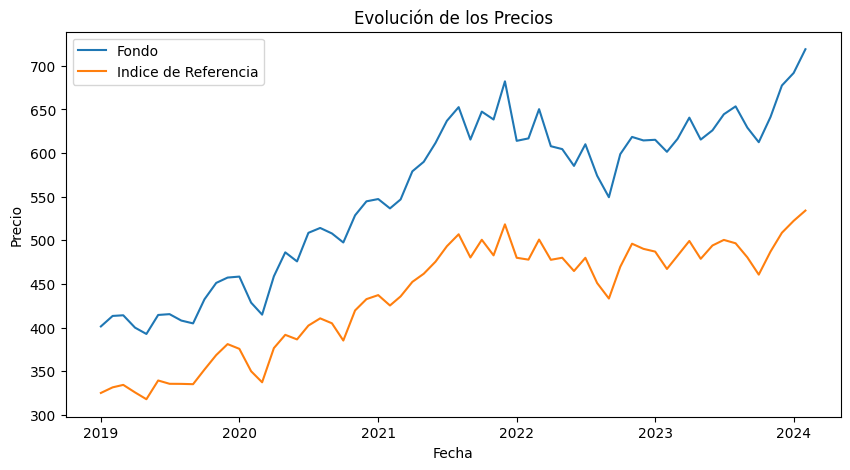

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(precios.index, precios['fondo'], '-', label='Fondo')
plt.plot(precios.index, precios['mkt'], '-', label='Indice de Referencia')
plt.title('Evolución de los Precios')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()

In [105]:
retornos = np.log(precios).diff().dropna()
retornos.head()

,fondo,mkt
Date,,
2019-02-01,0.029558,0.019522
2019-03-01,0.001788,0.008499
2019-04-01,-0.034790,-0.026116
2019-05-01,-0.018267,-0.024265
2019-06-01,0.053951,0.065311


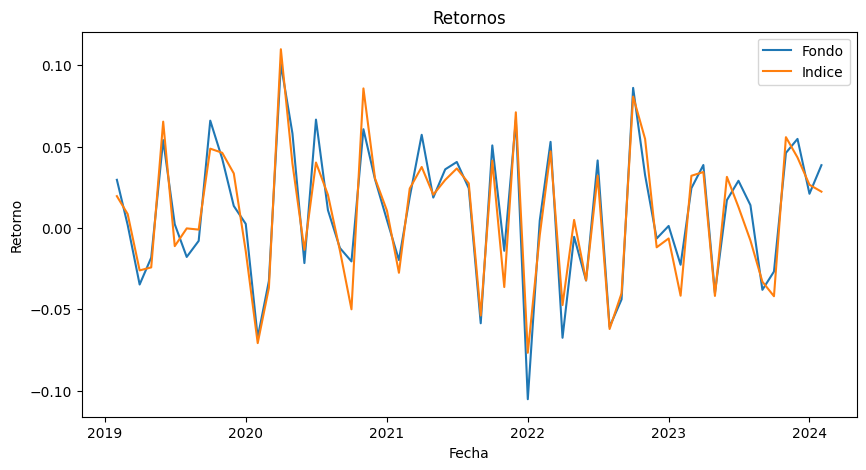

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(retornos, label=['Fondo', 'Indice'])
plt.title('Retornos')
plt.xlabel('Fecha')
plt.ylabel('Retorno')
plt.legend()

In [107]:
retornos_esperados = retornos.mean()
riesgos = retornos.std()
retornos_esperados * 12

fondo    0.114675
mkt      0.097626
dtype: float64

In [108]:
riesgos * 12

fondo    0.500615
mkt      0.494420
dtype: float64

In [109]:
factors = pd.read_csv('F-F_Research_Data_Factors.CSV', skiprows=3)
factors.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [110]:
factors.columns = ['date', 'mkt-rf', 'smb', 'hml', 'rf']
factors.head()

,date,mkt-rf,smb,hml,rf
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [111]:
factors['date'] = factors['date'].astype(str)
factors = factors[factors['date'].str.len() == 6]
factors.head()

,date,mkt-rf,smb,hml,rf
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [112]:
factors['date'] = pd.to_datetime(factors['date'],format='%Y%m', errors='coerce').dt.strftime("%Y-%m")
factors.head()

,date,mkt-rf,smb,hml,rf
0,1926-07,2.96,-2.56,-2.43,0.22
1,1926-08,2.64,-1.17,3.82,0.25
2,1926-09,0.36,-1.40,0.13,0.23
3,1926-10,-3.24,-0.09,0.70,0.32
4,1926-11,2.53,-0.10,-0.51,0.31


In [113]:
factors = factors.set_index('date')
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31


In [114]:
factors = factors.loc['2019-02':'2024-02']
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02,3.40,2.05,-2.67,0.18
2019-03,1.10,-3.05,-4.17,0.19
2019-04,3.97,-1.74,2.15,0.21
2019-05,-6.94,-1.32,-2.37,0.21
2019-06,6.93,0.29,-0.71,0.18


In [115]:
factors.index = pd.to_datetime(factors.index)
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02-01,3.40,2.05,-2.67,0.18
2019-03-01,1.10,-3.05,-4.17,0.19
2019-04-01,3.97,-1.74,2.15,0.21
2019-05-01,-6.94,-1.32,-2.37,0.21
2019-06-01,6.93,0.29,-0.71,0.18


In [116]:
factors.tail()

,mkt-rf,smb,hml,rf
date,,,,
2023-10-01,-3.19,-3.87,0.19,0.47
2023-11-01,8.84,-0.02,1.64,0.44
2023-12-01,4.87,6.34,4.93,0.43
2024-01-01,0.71,-5.09,-2.38,0.47
2024-02-01,5.06,-0.24,-3.48,0.42


In [117]:
factors = factors.apply(pd.to_numeric, errors='coerce').div(100)
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02-01,0.0340,0.0205,-0.0267,0.0018
2019-03-01,0.0110,-0.0305,-0.0417,0.0019
2019-04-01,0.0397,-0.0174,0.0215,0.0021
2019-05-01,-0.0694,-0.0132,-0.0237,0.0021
2019-06-01,0.0693,0.0029,-0.0071,0.0018


In [118]:
factors['mkt-rf'] = retornos['mkt'] - factors['rf']
factors.head()

,mkt-rf,smb,hml,rf
date,,,,
2019-02-01,0.017722,0.0205,-0.0267,0.0018
2019-03-01,0.006599,-0.0305,-0.0417,0.0019
2019-04-01,-0.028216,-0.0174,0.0215,0.0021
2019-05-01,-0.026365,-0.0132,-0.0237,0.0021
2019-06-01,0.063511,0.0029,-0.0071,0.0018


In [119]:
excess_returns = retornos['fondo'] - factors['rf']
excess_returns.head()

Date
2019-02-01    0.027758
2019-03-01   -0.000112
2019-04-01   -0.036890
2019-05-01   -0.020367
2019-06-01    0.052151
dtype: float64

In [120]:
factors = factors.drop('rf', axis=1)
factors.head()

,mkt-rf,smb,hml
date,,,
2019-02-01,0.017722,0.0205,-0.0267
2019-03-01,0.006599,-0.0305,-0.0417
2019-04-01,-0.028216,-0.0174,0.0215
2019-05-01,-0.026365,-0.0132,-0.0237
2019-06-01,0.063511,0.0029,-0.0071


In [121]:
factors = sm.add_constant(factors)
factors.head()

,const,mkt-rf,smb,hml
date,,,,
2019-02-01,1.0,0.017722,0.0205,-0.0267
2019-03-01,1.0,0.006599,-0.0305,-0.0417
2019-04-01,1.0,-0.028216,-0.0174,0.0215
2019-05-01,1.0,-0.026365,-0.0132,-0.0237
2019-06-01,1.0,0.063511,0.0029,-0.0071


In [122]:
retornos_positivos = retornos[retornos['mkt'] > 0]
retornos_negativos = retornos[retornos['mkt'] < 0]

In [123]:
covar = retornos.cov().iloc[0, 1]
benchmark_var = retornos.cov().iloc[1, 1]
beta = covar / benchmark_var
beta

0.9629405436835352

In [124]:
covar_positivos = retornos_positivos.cov().iloc[0, 1]
benchmark_var_positivos = retornos_positivos.cov().iloc[1, 1]
bull_beta = covar_positivos / benchmark_var_positivos
bull_beta

0.887243334765261

In [125]:
covar_negativos = retornos_negativos.cov().iloc[0, 1]
benchmark_var_negativos = retornos_negativos.cov().iloc[1, 1]
bear_beta = covar_negativos / benchmark_var_negativos
bear_beta

1.1055401125614368

In [126]:
apt_model = sm.OLS(excess_returns, factors).fit()

print(apt_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     197.2
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           4.66e-30
Time:                        14:12:00   Log-Likelihood:                 181.81
No. Observations:                  61   AIC:                            -355.6
Df Residuals:                      57   BIC:                            -347.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      1.050      0.2

In [127]:
capm_model = sm.OLS(excess_returns, factors.iloc[:, :2]).fit()
print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     560.7
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           8.05e-32
Time:                        14:12:00   Log-Likelihood:                 179.38
No. Observations:                  61   AIC:                            -354.8
Df Residuals:                      59   BIC:                            -350.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.002      0.991      0.3

In [128]:
results = {'alpha': apt_model.params[0],
        'beta': apt_model.params[1],
        'smb': apt_model.params[2],
        'hml': apt_model.params[3],
        'p_value_alpha': apt_model.pvalues[0],
        'p_value_beta': apt_model.pvalues[1],
        'p_value_smb': apt_model.pvalues[2],
        'p_value_hml': apt_model.pvalues[3],
        't_value_alpha': apt_model.tvalues[0],
        't_value_beta': apt_model.tvalues[1],
        't_value_smb': apt_model.tvalues[2],
        't_value_hml': apt_model.tvalues[3],
        'rsquared': apt_model.rsquared}
results_data = pd.DataFrame.from_dict(results, orient='index', columns=['Values'])
results_data.to_csv('ResultadosRegresion.csv')

C:\Users\danto\AppData\Local\Temp\ipykernel_17812\1655520177.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results = {'alpha': apt_model.params[0],
C:\Users\danto\AppData\Local\Temp\ipykernel_17812\1655520177.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta': apt_model.params[1],
C:\Users\danto\AppData\Local\Temp\ipykernel_17812\1655520177.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'smb': apt_model.params[2],

In [129]:
### INDICADORES DE RIESGO ###

ratio_informacion = (retornos_esperados['fondo'] - retornos_esperados['mkt']) / excess_returns.std()

ratio_treynor = (retornos_esperados['fondo'] - retornos_esperados['mkt']) / beta

def downside_risk(returns, risk_free=0):
    adj_returns = returns - risk_free
    sqr_downside = np.square(np.clip(adj_returns, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside))

def sortino(returns, risk_free=0):
    drisk = downside_risk(returns, risk_free)
    if drisk == 0:
        return np.nan
    adj_returns = returns - risk_free
    mean_return = np.nanmean(adj_returns)
    return mean_return / drisk

ratio_sortino = sortino(retornos['fondo'], retornos['fondo'] - excess_returns)

results_ratios = {'Beta': beta,
                  'Ratio Informacion': ratio_informacion,
                  'Ratio Treynor': ratio_treynor,
                  'Ratio Sortino': ratio_sortino,
                  'Bull Beta': bull_beta,
                  'Bear Beta': bear_beta}

results_ratios = pd.DataFrame.from_dict(results_ratios, orient='index', columns=['Values'])

results_ratios.to_csv('ResultadosRatios.csv')

print(f'Beta: {round(beta, 4)}\nRatio Informacion: {round(ratio_informacion, 4)}\nRatio Treynor: {round(ratio_treynor, 4)}\nRatio Sortino: {round(ratio_sortino, 4)}\nBull Beta; {round(bull_beta, 4)}\nBear Beta: {round(bear_beta, 4)}')

Beta: 0.9629
Ratio Informacion: 0.034
Ratio Treynor: 0.0015
Ratio Sortino: 0.3066
Bull Beta; 0.8872
Bear Beta: 1.1055


In [130]:
factors_industry = pd.read_csv('5_Industry_Portfolios.CSV', skiprows=11)
factors_industry.head()

,Unnamed: 0,Cnsmr,Manuf,HiTec,Hlth,Other
0,192607,5.43,2.73,1.83,1.77,2.13
1,192608,2.76,2.33,2.41,4.25,4.35
2,192609,2.16,-0.44,1.06,0.69,0.29
3,192610,-3.90,-2.42,-2.26,-0.57,-2.84
4,192611,3.70,2.50,3.07,5.42,2.11


In [131]:
factors_industry.columns = ['date', 'cnsmr', 'manuf', 'hitec', 'hlth', 'other']
factors_industry.head()

,date,cnsmr,manuf,hitec,hlth,other
0,192607,5.43,2.73,1.83,1.77,2.13
1,192608,2.76,2.33,2.41,4.25,4.35
2,192609,2.16,-0.44,1.06,0.69,0.29
3,192610,-3.90,-2.42,-2.26,-0.57,-2.84
4,192611,3.70,2.50,3.07,5.42,2.11


In [132]:
factors_industry['date'] = factors_industry['date'].astype(str)

In [133]:
factors_industry = factors_industry[factors_industry['date'].str.len() == 6]
factors_industry.head()

,date,cnsmr,manuf,hitec,hlth,other
0,192607,5.43,2.73,1.83,1.77,2.13
1,192608,2.76,2.33,2.41,4.25,4.35
2,192609,2.16,-0.44,1.06,0.69,0.29
3,192610,-3.90,-2.42,-2.26,-0.57,-2.84
4,192611,3.70,2.50,3.07,5.42,2.11


In [134]:
factors_industry['date'] = pd.to_datetime(factors_industry['date'],format='%Y%m', errors='coerce').dt.strftime("%Y-%m")
factors_industry.head()

,date,cnsmr,manuf,hitec,hlth,other
0,1926-07,5.43,2.73,1.83,1.77,2.13
1,1926-08,2.76,2.33,2.41,4.25,4.35
2,1926-09,2.16,-0.44,1.06,0.69,0.29
3,1926-10,-3.90,-2.42,-2.26,-0.57,-2.84
4,1926-11,3.70,2.50,3.07,5.42,2.11


In [135]:
factors_industry = factors_industry.set_index('date')

In [136]:
factors_industry = factors_industry.loc['2019-02':'2024-02']
factors_industry.head()

,cnsmr,manuf,hitec,hlth,other
date,,,,,
2019-02,1.09,4.16,5.39,3.30,2.96
2019-03,2.85,0.72,3.32,0.50,-1.47
2019-04,4.11,2.43,5.87,-3.16,6.63
2019-05,-6.35,-8.25,-7.72,-3.40,-6.17
2019-06,6.88,7.27,7.63,6.83,6.64


In [137]:
factors_industry.index = pd.to_datetime(factors_industry.index)
factors_industry.head()

,cnsmr,manuf,hitec,hlth,other
date,,,,,
2019-02-01,1.09,4.16,5.39,3.30,2.96
2019-03-01,2.85,0.72,3.32,0.50,-1.47
2019-04-01,4.11,2.43,5.87,-3.16,6.63
2019-05-01,-6.35,-8.25,-7.72,-3.40,-6.17
2019-06-01,6.88,7.27,7.63,6.83,6.64


In [138]:
factors_industry = factors_industry.apply(pd.to_numeric, errors='coerce').div(100)
factors_industry.head()

,cnsmr,manuf,hitec,hlth,other
date,,,,,
2019-02-01,0.0109,0.0416,0.0539,0.0330,0.0296
2019-03-01,0.0285,0.0072,0.0332,0.0050,-0.0147
2019-04-01,0.0411,0.0243,0.0587,-0.0316,0.0663
2019-05-01,-0.0635,-0.0825,-0.0772,-0.0340,-0.0617
2019-06-01,0.0688,0.0727,0.0763,0.0683,0.0664


In [139]:
x = sm.add_constant(factors_industry)

model_industry = sm.OLS(excess_returns, x).fit()

print(model_industry.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     67.24
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           3.46e-22
Time:                        14:12:00   Log-Likelihood:                 167.48
No. Observations:                  61   AIC:                            -323.0
Df Residuals:                      55   BIC:                            -310.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.190      0.8

In [140]:
results_industry = {'alpha': model_industry.params[0],
        'Consume': model_industry.params[1],
        'Manufacture': model_industry.params[2],
        'Hi-Tech': model_industry.params[3],
        'Health': model_industry.params[4],
        'Other': model_industry.params[5],
        'p_value_alpha': model_industry.pvalues[0],
        'p_value_cnsmr': model_industry.pvalues[1],
        'p_value_manuf': model_industry.pvalues[2],
        'p_value_hitech': model_industry.pvalues[3],
        'p_value_hlth': model_industry.pvalues[4],
        'p_value_other': model_industry.pvalues[5],
        't_value_alpha': model_industry.tvalues[0],
        't_value_cnsmr': model_industry.tvalues[1],
        't_value_manuf': model_industry.tvalues[2],
        't_value_hitech': model_industry.tvalues[3],
        't_value_hlth': model_industry.tvalues[4],
        't_value_other': model_industry.tvalues[5],
        'rsquared': model_industry.rsquared}

results_industry = pd.DataFrame.from_dict(results_industry, orient='index', columns=['Values'])
results_industry.to_csv('ResultadosRegresionIndustry.csv')

C:\Users\danto\AppData\Local\Temp\ipykernel_17812\2047815666.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_industry = {'alpha': model_industry.params[0],
C:\Users\danto\AppData\Local\Temp\ipykernel_17812\2047815666.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Consume': model_industry.params[1],
C:\Users\danto\AppData\Local\Temp\ipykernel_17812\2047815666.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Manu

In [141]:
datos_fondo = pd.read_excel('9957_AB_SICAV_I_-_INTERNATIONAL_HEALTH_CARE_PORTFOLIO_full_holdings_0224.xlsx', skiprows=6, nrows=43).iloc[:, [3, 4]]
datos_fondo.head()

,% of Net Assets,ISIN (Primary ID)
0,0.080570,US5324571083
1,0.075152,DK0062498333
2,0.073393,US91324P1021
3,0.057372,US58933Y1055
4,0.049698,CH0012032048


In [142]:
datos_fondo.columns = ['pesos', 'isin']
datos_fondo.head()

,pesos,isin
0,0.080570,US5324571083
1,0.075152,DK0062498333
2,0.073393,US91324P1021
3,0.057372,US58933Y1055
4,0.049698,CH0012032048


In [143]:
def get_symbol_for_isin(isin):
    url = 'https://query1.finance.yahoo.com/v1/finance/search'

    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.109 Safari/537.36',
    }

    params = dict(
        q=isin,
        quotesCount=1,
        newsCount=0,
        listsCount=0,
        quotesQueryId='tss_match_phrase_query'
    )

    resp = requests.get(url=url, headers=headers, params=params)
    data = resp.json()
    if 'quotes' in data and len(data['quotes']) > 0:
        return data['quotes'][0]['symbol']
    else:
        return None

In [144]:
tickers = []
error = []
isin = list(datos_fondo['isin'])

for code in isin:
    ticker = get_symbol_for_isin(code)
    if ticker == None:
        error.append(code)
        print('Error al encontrar ticker.')
    tickers.append(ticker)

datos_fondo['tickers'] = tickers

datos_fondo.head()

Error al encontrar ticker.


,pesos,isin,tickers
0,0.080570,US5324571083,LLY
1,0.075152,DK0062498333,NOVO-B.CO
2,0.073393,US91324P1021,UNH
3,0.057372,US58933Y1055,MRK
4,0.049698,CH0012032048,ROG.SW


In [145]:
error

['US003CVR0169']

In [146]:
datos_fondo_ordenado = datos_fondo.sort_values(by='tickers')
datos_fondo_ordenado.head()

,pesos,isin,tickers
38,0.003131,HK1093012172,1093.HK
34,0.004285,JP3435750009,2413.T
40,0.002046,JP3717600005,4516.T
26,0.008383,JP3519400000,4519.T
39,0.003019,JP3982400008,4527.T


In [147]:
datos_fondo.shape

(43, 3)

In [148]:
datos_fondo_ordenado = datos_fondo_ordenado.dropna()
datos_fondo_ordenado.shape

(42, 3)

In [149]:
tickers = list(datos_fondo_ordenado['tickers'])

In [150]:
raw = yf.download(tickers,
                start='2019-01-01',
                end='2024-02-28',
                interval='1mo')['Adj Close']
raw.head()

[*********************100%%**********************]  42 of 42 completed


Ticker,1093.HK,2413.T,4516.T,4519.T,4527.T,4528.T,AFX.DE,ALGN,AMGN,BANB.SW,...,REGN,ROG.SW,STMN.SW,STVN,UNH,UTHR,VEEV,VRTX,WAT,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,6.248820,1522.742188,6370.895996,1961.025269,1398.777466,2107.104248,75.224983,248.949997,159.341446,21.538147,...,429.269989,216.939255,69.932701,NaN,249.760864,115.330002,109.059998,190.910004,231.220001,83.095428
2019-02-01,6.220964,1796.154907,6527.860352,2312.299072,1400.691772,2034.216064,71.280785,258.970001,161.870728,21.160944,...,430.739990,227.911530,75.610786,NaN,223.897385,126.290001,117.910004,188.750000,242.220001,91.057861
2019-03-01,6.778066,1806.858032,7441.946289,2324.517334,1360.015747,1927.994141,70.758057,284.329987,163.036438,23.122387,...,410.619995,224.541779,78.959396,NaN,228.556091,117.370003,126.860001,183.949997,251.710007,97.281075
2019-04-01,7.019478,1923.145996,7110.186035,2150.407471,1491.708496,1867.291992,83.790688,324.679993,153.888336,24.521515,...,343.140015,227.826050,79.842667,NaN,216.261810,102.570000,139.869995,168.979996,213.539993,98.411667
2019-05-01,5.868134,2004.213135,6980.233398,2211.498535,1417.482300,1724.068359,80.632385,284.350006,143.058121,24.188541,...,301.720001,223.160950,80.527969,NaN,224.362228,83.970001,154.289993,166.179993,200.710007,97.810028


In [151]:
pesos_fondo = pd.DataFrame([list(datos_fondo_ordenado['pesos'])], columns=raw.columns)

In [152]:
raw_pesos = pd.concat([raw, pesos_fondo], ignore_index=False)
raw_pesos.tail()

Ticker,1093.HK,2413.T,4516.T,4519.T,4527.T,4528.T,AFX.DE,ALGN,AMGN,BANB.SW,...,REGN,ROG.SW,STMN.SW,STVN,UNH,UTHR,VEEV,VRTX,WAT,ZTS
2023-11-01 00:00:00,7.050000,2421.591553,5259.520508,5179.233398,3075.000000,2677.971680,80.771431,213.800003,265.461243,65.000000,...,823.809998,226.647186,120.250000,26.389999,548.926025,240.000000,174.309998,354.809998,280.609985,176.270203
2023-12-01 00:00:00,7.260000,2310.191406,4929.012207,5302.312012,2829.198975,2476.213379,96.980659,274.000000,285.785889,65.000000,...,878.289978,234.760574,135.600006,27.290001,522.619812,219.889999,192.520004,406.890015,329.230011,196.923355
2024-01-01 00:00:00,5.740000,2331.481201,5164.807617,5347.000000,3023.252441,2629.746582,96.705933,267.320007,311.822357,58.200001,...,942.780029,237.257019,132.399994,31.740000,509.730560,214.779999,207.410004,433.380005,317.709991,187.384995
2024-02-01 00:00:00,6.120000,2125.514648,4706.042480,6000.000000,3026.237793,2448.656250,111.610184,302.420013,271.705963,70.000000,...,966.090027,222.710495,139.600006,33.150002,491.661804,225.639999,225.509995,420.739990,337.420013,198.330002
0,0.003131,0.004285,0.002046,0.008383,0.003019,0.004116,0.012811,0.011094,0.039721,0.004550,...,0.045742,0.049698,0.007011,0.001688,0.073393,0.008046,0.024265,0.042327,0.018982,0.030461


In [153]:
threshold = 0.90
precios_activos = raw_pesos.dropna(axis=1, thresh=len(raw) * threshold)

In [154]:
pesos_fondo = precios_activos.iloc[-1]
precios_activos = precios_activos.drop(precios_activos.index[-1])
precios_activos.tail()

Ticker,1093.HK,2413.T,4516.T,4519.T,4527.T,4528.T,AFX.DE,ALGN,AMGN,BANB.SW,...,PEN,REGN,ROG.SW,STMN.SW,UNH,UTHR,VEEV,VRTX,WAT,ZTS
2023-10-01 00:00:00,6.83,2291.377197,6012.290039,4426.864746,3475.048584,2560.361328,80.202339,184.589996,251.737259,65.599998,...,191.149994,779.890015,224.534821,106.949997,531.643372,222.860001,192.710007,362.109985,238.529999,156.270569
2023-11-01 00:00:00,7.05,2421.591553,5259.520508,5179.233398,3075.000000,2677.971680,80.771431,213.800003,265.461243,65.000000,...,222.089996,823.809998,226.647186,120.250000,548.926025,240.000000,174.309998,354.809998,280.609985,176.270203
2023-12-01 00:00:00,7.26,2310.191406,4929.012207,5302.312012,2829.198975,2476.213379,96.980659,274.000000,285.785889,65.000000,...,251.539993,878.289978,234.760574,135.600006,522.619812,219.889999,192.520004,406.890015,329.230011,196.923355
2024-01-01 00:00:00,5.74,2331.481201,5164.807617,5347.000000,3023.252441,2629.746582,96.705933,267.320007,311.822357,58.200001,...,252.190002,942.780029,237.257019,132.399994,509.730560,214.779999,207.410004,433.380005,317.709991,187.384995
2024-02-01 00:00:00,6.12,2125.514648,4706.042480,6000.000000,3026.237793,2448.656250,111.610184,302.420013,271.705963,70.000000,...,234.919998,966.090027,222.710495,139.600006,491.661804,225.639999,225.509995,420.739990,337.420013,198.330002


In [155]:
retornos_activos = np.log(precios_activos).diff().dropna()
retornos_activos.head()

Ticker,1093.HK,2413.T,4516.T,4519.T,4527.T,4528.T,AFX.DE,ALGN,AMGN,BANB.SW,...,PEN,REGN,ROG.SW,STMN.SW,UNH,UTHR,VEEV,VRTX,WAT,ZTS
2019-02-01 00:00:00,-0.004468,0.165135,0.024339,0.164775,0.001368,-0.035204,-0.053857,0.039460,0.015749,-0.017668,...,-0.084871,0.003419,0.049340,0.078066,-0.109316,0.090783,0.078023,-0.011379,0.046477,0.091505
2019-03-01 00:00:00,0.085767,0.005941,0.131053,0.005270,-0.029470,-0.053630,-0.007360,0.093423,0.007176,0.088644,...,0.095127,-0.047836,-0.014896,0.043335,0.020594,-0.073249,0.073162,-0.025759,0.038431,0.066109
2019-04-01 00:00:00,0.034997,0.062373,-0.045604,-0.077855,0.092426,-0.031991,0.169055,0.132705,-0.057746,0.058750,...,-0.088936,-0.179530,0.014521,0.011124,-0.055292,-0.134786,0.097629,-0.084884,-0.164454,0.011555
2019-05-01 00:00:00,-0.179152,0.041289,-0.018446,0.028013,-0.051040,-0.079802,-0.038422,-0.132634,-0.072976,-0.013672,...,0.059180,-0.128639,-0.020689,0.008547,0.036772,-0.200086,0.098121,-0.016709,-0.061963,-0.006132
2019-06-01 00:00:00,0.010540,-0.041289,0.010582,-0.028013,-0.012237,0.006231,0.029242,-0.038173,0.108833,0.028304,...,0.114429,0.036704,0.042963,0.043903,0.009098,-0.072982,0.049441,0.098489,0.069893,0.116099


In [156]:
retornos_esperados_activos = retornos_activos.mean().to_numpy()
riesgos_activos = retornos_activos.std().to_numpy()

In [157]:
pesos_fondo = list(pesos_fondo)

In [158]:
retornos_cartera = retornos_activos @ pesos_fondo

In [159]:
rentabilidad_cartera = retornos_cartera.mean()
riesgo_cartera = retornos_cartera.std()

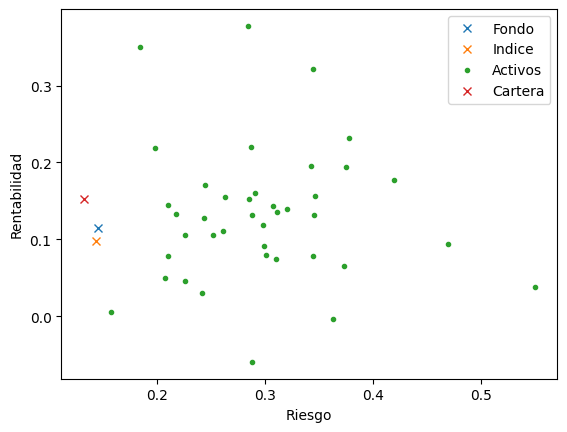

In [160]:
plt.plot(riesgos['fondo'] * np.sqrt(12), retornos_esperados['fondo'] * 12, 'x', label='Fondo')
plt.plot(riesgos['mkt'] * np.sqrt(12), retornos_esperados['mkt'] * 12, 'x', label='Indice')
plt.plot(riesgos_activos * np.sqrt(12), retornos_esperados_activos * 12, '.', label='Activos')
plt.plot(riesgo_cartera * np.sqrt(12), rentabilidad_cartera * 12, 'x', label='Cartera')
plt.xlabel('Riesgo')
plt.ylabel('Rentabilidad')
plt.legend()

In [161]:
num_activos = len(retornos_activos.columns)
num_activos

40

In [162]:
matriz_cov = retornos_activos.cov().to_numpy()

In [163]:
pesos = cp.Variable(num_activos)

rent = retornos_esperados_activos @ pesos
risk = cp.quad_form(pesos, matriz_cov)

restricciones = [cp.sum(pesos) == 1,
                 pesos >= 0]

objetivo = cp.Minimize(risk)

problema = cp.Problem(objetivo, restricciones)

resultado = problema.solve('ECOS')

In [164]:
pesos_min_risk = pesos.value
retornos_min_risk = retornos_activos @ pesos_min_risk
rent_min_risk = retornos_min_risk.mean()
riesgo_min_risk = retornos_min_risk.std()

In [165]:
imax = np.argmax(retornos_activos.mean())
max_riesgo = np.sqrt(matriz_cov[imax, imax])
riesgos_frontera = np.linspace(riesgo_min_risk, max_riesgo, 200)
rentabilidades_frontera = []
for risk in riesgos_frontera:
    pesos = cp.Variable(num_activos)

    rent = retornos_esperados_activos @ pesos
    riesgo = cp.quad_form(pesos, matriz_cov)
    
    restricciones = [cp.sum(pesos) == 1,
                     pesos >= 0,
                     riesgo <= risk**2]

    objetivo = cp.Maximize(rent)

    problema = cp.Problem(objetivo, restricciones)

    resultado = problema.solve("ECOS")
    
    pesos = pesos.value
    retornos_frontera = retornos_activos @ pesos
    rent = retornos_frontera.mean()
    rentabilidades_frontera.append(rent)
rentabilidades_frontera = np.array(rentabilidades_frontera)

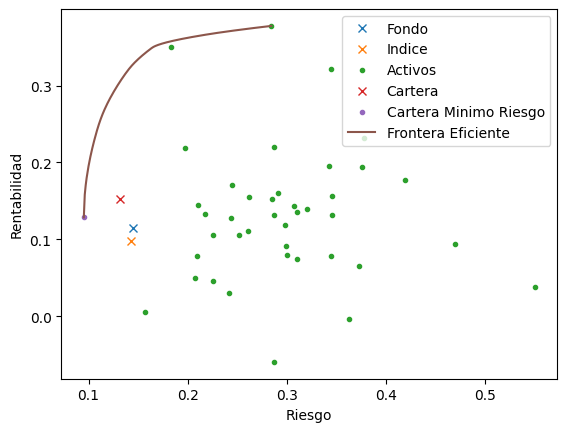

In [166]:
plt.plot(riesgos['fondo'] * np.sqrt(12), retornos_esperados['fondo'] * 12, 'x', label='Fondo')
plt.plot(riesgos['mkt'] * np.sqrt(12), retornos_esperados['mkt'] * 12, 'x', label='Indice')
plt.plot(riesgos_activos * np.sqrt(12), retornos_esperados_activos * 12, '.', label='Activos')
plt.plot(riesgo_cartera * np.sqrt(12), rentabilidad_cartera * 12, 'x', label='Cartera')
plt.plot(riesgo_min_risk * np.sqrt(12), rent_min_risk * 12, '.', label='Cartera Minimo Riesgo')
plt.plot(riesgos_frontera * np.sqrt(12), rentabilidades_frontera * 12, '-', label='Frontera Eficiente')
plt.xlabel('Riesgo')
plt.ylabel('Rentabilidad')
plt.legend()

In [167]:
pesos = cp.Variable(num_activos)

rent = retornos_esperados_activos @ pesos
riesgo = cp.quad_form(pesos, matriz_cov)

restricciones = [cp.sum(pesos) == 1,
                    pesos >= 0,
                    riesgo <= riesgos['fondo']**2]

objetivo = cp.Maximize(rent)

problema = cp.Problem(objetivo, restricciones)

resultado = problema.solve("ECOS")

In [168]:
pesos_max_rent = pesos.value
retornos_max_rent = retornos_activos @ pesos_max_rent
rent_max_rent = retornos_max_rent.mean()
riesgo_max_rent = retornos_max_rent.std()

In [169]:
pesos_max_rent[pesos_max_rent <= 1e-4] = 0

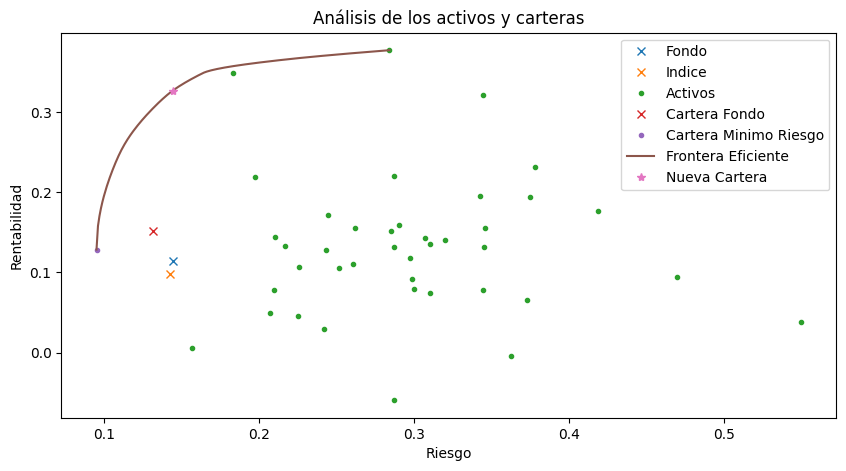

In [170]:
plt.figure(figsize=(10, 5))
plt.plot(riesgos['fondo'] * np.sqrt(12), retornos_esperados['fondo'] * 12, 'x', label='Fondo')
plt.plot(riesgos['mkt'] * np.sqrt(12), retornos_esperados['mkt'] * 12, 'x', label='Indice')
plt.plot(riesgos_activos * np.sqrt(12), retornos_esperados_activos * 12, '.', label='Activos')
plt.plot(riesgo_cartera * np.sqrt(12), rentabilidad_cartera * 12, 'x', label='Cartera Fondo')
plt.plot(riesgo_min_risk * np.sqrt(12), rent_min_risk * 12, '.', label='Cartera Minimo Riesgo')
plt.plot(riesgos_frontera * np.sqrt(12), rentabilidades_frontera * 12, '-', label='Frontera Eficiente')
plt.plot(riesgo_max_rent * np.sqrt(12), rent_max_rent * 12, '*', label='Nueva Cartera')
plt.title('Análisis de los activos y carteras')
plt.xlabel('Riesgo')
plt.ylabel('Rentabilidad')
plt.legend()

In [171]:
cartera = pd.DataFrame()
cartera['activos'] = retornos_activos.columns
cartera['pesos'] = pesos_max_rent

In [172]:
cartera = cartera[cartera['pesos'] > 0]

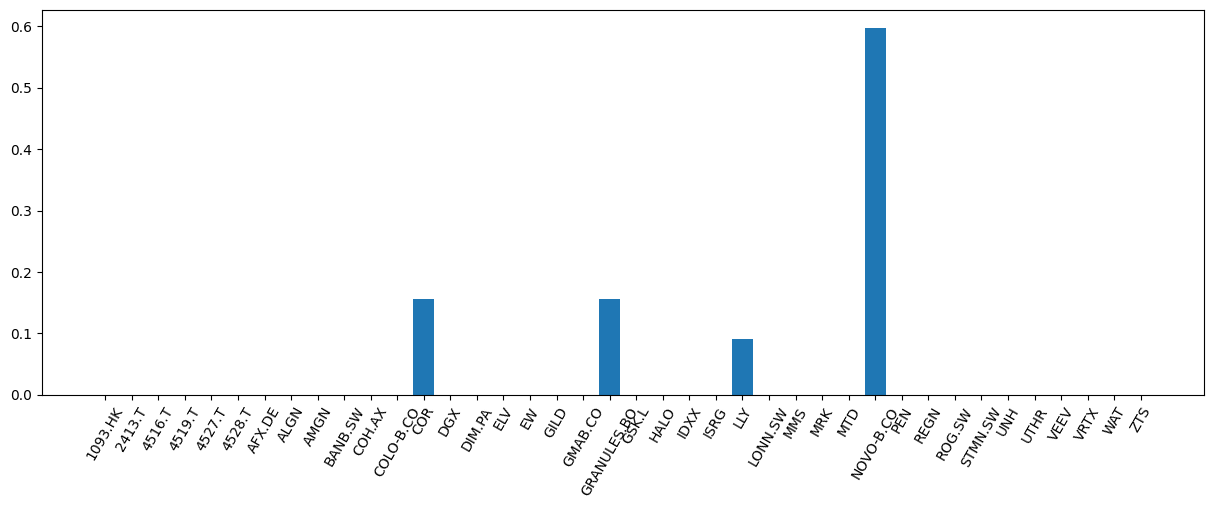

In [173]:
plt.figure(figsize=(15, 5))
plt.bar(retornos_activos.columns, pesos_max_rent)
plt.xticks(retornos_activos.columns, rotation=60)
plt.show()

([<matplotlib.patches.Wedge at 0x17d6ccff010>,
 [Text(-0.5207070019649106, 0.9689500596546319, 'COR'),
  Text(-1.0949030161428357, 0.10577043651853531, 'GRANULES.BO'),
  Text(-0.8580260145927134, -0.688325038250204, 'LLY'),
  Text(1.0491367441550605, -0.33062379234368366, 'NOVO-B.CO')],
 [Text(-0.2840220010717694, 0.5285182143570719, '15.7%'),
  Text(-0.5972198269870013, 0.057692965373746526, '15.5%'),
  Text(-0.46801418977784365, -0.3754500208637476, '9.0%'),
  Text(0.5722564059027602, -0.180340250369282, '59.7%')])

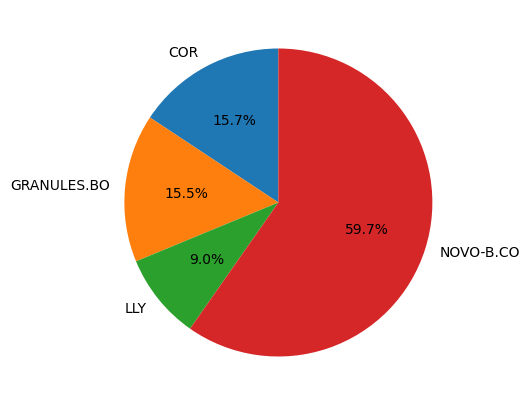

In [174]:
plt.figure(figsize=(20, 5))
plt.pie(cartera['pesos'], labels=cartera['activos'], autopct='%1.1f%%', startangle=90)

In [175]:
skewness_fondo = pd.DataFrame([retornos['fondo'].skew()], columns=['Fondo'])
skewness_cartera = pd.DataFrame([retornos_max_rent.skew()], columns=['Cartera'])

kurtosis_fondo = pd.DataFrame([retornos['fondo'].kurtosis()], columns=['Fondo'])
kurtosis_cartera = pd.DataFrame([retornos_max_rent.kurtosis()], columns=['Cartera'])

In [176]:
skewness = pd.concat([skewness_fondo, skewness_cartera], axis=1)
skewness

,Fondo,Cartera
0,-0.298731,-0.4059


In [177]:
kurtosis = pd.concat([kurtosis_fondo, kurtosis_cartera], axis=1)
kurtosis

,Fondo,Cartera
0,-0.108963,-0.151532


In [178]:
datos_ordenados_pesos = datos_fondo.sort_values('pesos', ascending=False)
datos_ordenados_pesos = datos_ordenados_pesos.head(10)

In [179]:
tickers_10 = list(datos_ordenados_pesos['tickers'])

precios_10_activos = yf.download(tickers_10,
                                start='2019-01-01',
                                end='2024-02-28',
                                interval='1mo')['Adj Close']
precios_10_activos.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,AMGN,ELV,GSK.L,LLY,MRK,NOVO-B.CO,REGN,ROG.SW,UNH,VRTX
Date,,,,,,,,,,
2019-01-01,159.341446,284.367096,1109.866943,110.383629,60.558559,137.684418,429.269989,216.939255,249.760864,190.910004
2019-02-01,161.870728,282.236755,1125.043701,116.305267,66.140076,145.673035,430.739990,227.911530,223.897385,188.750000
2019-03-01,163.036438,269.332306,1221.881470,120.148598,67.669708,157.689835,410.619995,224.541779,228.556091,183.949997
2019-04-01,153.888336,247.503311,1203.975708,108.370796,64.475487,149.559891,343.140015,227.826050,216.261810,168.979996
2019-05-01,143.058121,261.570801,1168.470215,107.352264,64.885063,144.597519,301.720001,223.160950,224.362228,166.179993


In [180]:
retornos_10 = np.log(precios_10_activos).diff().dropna()
retornos_10.head()

Ticker,AMGN,ELV,GSK.L,LLY,MRK,NOVO-B.CO,REGN,ROG.SW,UNH,VRTX
Date,,,,,,,,,,
2019-02-01,0.015749,-0.007520,0.013582,0.052257,0.088164,0.056400,0.003419,0.049340,-0.109316,-0.011379
2019-03-01,0.007176,-0.046800,0.082570,0.032511,0.022864,0.079265,-0.047836,-0.014896,0.020594,-0.025759
2019-04-01,-0.057746,-0.084522,-0.014763,-0.103171,-0.048354,-0.052933,-0.179530,0.014521,-0.055292,-0.084884
2019-05-01,-0.072976,0.055281,-0.029934,-0.009443,0.006332,-0.033743,-0.128639,-0.020689,0.036772,-0.016709
2019-06-01,0.108833,0.015102,0.047454,-0.039842,0.056927,0.061017,0.036704,0.042963,0.009098,0.098489


In [181]:
X = sm.add_constant(retornos_10)

model = sm.OLS(excess_returns, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     8.088
Date:                Sun, 14 Apr 2024   Prob (F-statistic):           1.36e-07
Time:                        14:12:13   Log-Likelihood:                 137.00
No. Observations:                  61   AIC:                            -252.0
Df Residuals:                      50   BIC:                            -228.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0034      0.004     -0.793      0.4

In [182]:
results_activos = {'alpha': model.params[0],
        'ELV': model.params[2],
        'NOVO-B.CO': model.params[6],
        'p_value_alpha': model.pvalues[0],
        'p_value_elv': model.pvalues[2],
        'p_value_novo': model.pvalues[6],
        't_value_alpha': model.tvalues[0],
        't_value_elv': model.tvalues[2],
        't_value_novo': model.tvalues[6],
        'rsquared': model.rsquared}

results_activos = pd.DataFrame.from_dict(results_activos, orient='index', columns=['Values'])
results_activos.to_csv('ResultadosRegresionActivos.csv')

C:\Users\danto\AppData\Local\Temp\ipykernel_17812\29116364.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results_activos = {'alpha': model.params[0],
C:\Users\danto\AppData\Local\Temp\ipykernel_17812\29116364.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'ELV': model.params[2],
C:\Users\danto\AppData\Local\Temp\ipykernel_17812\29116364.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'NOVO-B.CO': model.params[6],
C:\U